In [13]:
import math
import numpy as np
import pandas as pd
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Create one random seed number for reproducible results
seedNum = 888

### Reading data

In [14]:
#[kannan: directly reading the data, later change the pipeline to preprocessed, feature engineered data]
inputFile = 'OnlineNewsPopularity.csv' 
df = read_csv(inputFile)
df.columns = df.columns.str.replace(' ','')
df.head()

,Id,url,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,shares
0,1,http://mashable.com/2014/09/01/americans-held-...,10,261,0.661355,1.0,0.787500,7,3,1,1,4.873563,7,0,0,0,0,0,1,1100
1,2,http://mashable.com/2014/09/01/apple-visa-mast...,7,1791,0.370242,1.0,0.535038,74,3,50,0,4.554439,8,0,0,0,0,0,0,1100
2,3,http://mashable.com/2014/09/01/aussie-football...,7,503,0.524291,1.0,0.704918,3,3,1,0,5.003976,5,0,0,0,0,0,1,1000
3,4,http://mashable.com/2014/09/01/australia-gover...,10,526,0.536204,1.0,0.654867,17,1,1,0,4.998099,9,0,0,0,0,0,1,822
4,5,http://mashable.com/2014/09/01/australia-jane-...,13,237,0.619048,1.0,0.807143,5,3,1,0,5.046414,9,0,0,0,0,0,1,841


In [15]:
# Dropping useless attributes
df.drop('url', axis=1, inplace=True)
df.drop('Id', axis=1, inplace=True)

In [16]:
# variables for total columns, total input attributes, target column index and renaming target variable
totCol = len(df.columns)
totAttr = totCol-1
targetCol = totCol #last column
df.rename(columns={'shares': 'targetVar'}, inplace=True)

In [17]:
#70:30 train test split
if targetCol == totCol :
    x_df = df.iloc[:,0:totAttr]
    y_df = df.iloc[:,totAttr]
else :
    x_df = df.iloc[:,1:totCol]
    y_df = df.iloc[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=validation_size, random_state=seedNum)
print("x_df.shape: {} y_df.shape: {}".format(x_df.shape, y_df.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_df.shape: (7795, 17) y_df.shape: (7795,)
x_train.shape: (5456, 17) y_train.shape: (5456,)
x_test.shape: (2339, 17) y_test.shape: (2339,)


In [18]:
# visualization configs
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

In [19]:
#kannan: This is decided from feature engineering / feature selection
lowAttributes=[]

In [20]:
# Removing the unselected attributes from the training and validation dataframes
#xy_train <- xy_train[, !(names(xy_train) %in% lowAttributes)]
#xy_test <- xy_test[, !(names(xy_test) %in% lowAttributes)]
xy_newdf = df.drop(lowAttributes, axis=1)

totCol = len(xy_newdf.columns)
totAttr = totCol-1
targetCol = totCol
array = xy_newdf.values

if targetCol == totCol :
    x_newdf = array[:,0:totAttr]
    y_newdf = array[:,totAttr]
else :
    x_newdf = array[:,1:totCol]
    y_newdf = array[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_newdf, y_newdf, test_size=validation_size, random_state=seedNum)
print("x_newdf.shape: {} y_newdf.shape: {}".format(x_newdf.shape, y_newdf.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_newdf.shape: (7795, 17) y_newdf.shape: (7795,)
x_train.shape: (5456, 17) y_train.shape: (5456,)
x_test.shape: (2339, 17) y_test.shape: (2339,)


## Traditional ML Models Evaluation

In [21]:
# Comparing various types of regression # K-fold cross validation
num_folds = 10
scoring = 'neg_mean_squared_error'
#Other scoring options: https://scikit-learn.org/stable/modules/model_evaluation.html
models = []

# LINEAR ALGORITHMS
# -----------------
# Linear Regression
models.append(('LR', LinearRegression()))
# Ridge Regression
models.append(('RR', Ridge(random_state=seedNum)))
# Lasso Regression
models.append(('LASSO', Lasso(random_state=seedNum)))
# Elastic Net
models.append(('EN', ElasticNet(random_state=seedNum)))

# NON-LINEAR ALGORITHMS
# ---------------------
# Classification and Regression Trees
models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
# K Nearest Neighbor
models.append(('KNN', KNeighborsRegressor()))
# Suppor Vector machine
models.append(('SVM', SVR()))

# ENSEMBLE ALGORITHMS
# -------------------
# Extra Trees
models.append(('ETree', ExtraTreesRegressor(random_state=seedNum)))
# Random Forest
models.append(('RF', RandomForestRegressor(random_state=seedNum)))
# Stochastic Gradient Boosting
models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# Adaptive Boosting
models.append(('ABM', AdaBoostRegressor(random_state=seedNum)))

results = []
names = []
metrics1= [] #RMSE_Training
metrics2= [] #RMSE_Testing

## Training

In [22]:
for name, model in models:
    startTimeModule = datetime.now()
    kfold = KFold(n_splits=num_folds, random_state=seedNum)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    rmse=math.sqrt(abs(cv_results.mean()))
    metrics1.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))
    print ('Model training time:',(datetime.now() - startTimeModule))


LR: rmse:7003.194071
Model training time: 0:00:00.065996

RR: rmse:7002.494004
Model training time: 0:00:00.021998

LASSO: rmse:7003.172732
Model training time: 0:00:00.388991

EN: rmse:7030.645838
Model training time: 0:00:00.022992

CART: rmse:9813.657545
Model training time: 0:00:00.442024

KNN: rmse:7616.415888
Model training time: 0:00:00.084999

SVM: rmse:7259.710113
Model training time: 0:00:18.933829

ETree: rmse:7766.932946
Model training time: 0:00:01.273748

RF: rmse:7631.819068
Model training time: 0:00:02.517520

GBM: rmse:7267.407348
Model training time: 0:00:02.899715

ABM: rmse:9212.585460
Model training time: 0:00:00.589444


## Testing

In [23]:
for name, model in models:
    model.fit(x_train, y_train)
    predictions=model.predict(x_test)
    rmse=math.sqrt(mean_squared_error(y_test, predictions))
    metrics2.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))


LR: rmse:10249.246629

RR: rmse:10249.738338

LASSO: rmse:10250.542304

EN: rmse:10289.080306

CART: rmse:13066.671798

KNN: rmse:10690.843568

SVM: rmse:10524.106516

ETree: rmse:11406.556473

RF: rmse:11066.789925

GBM: rmse:10414.852782

ABM: rmse:12955.848236


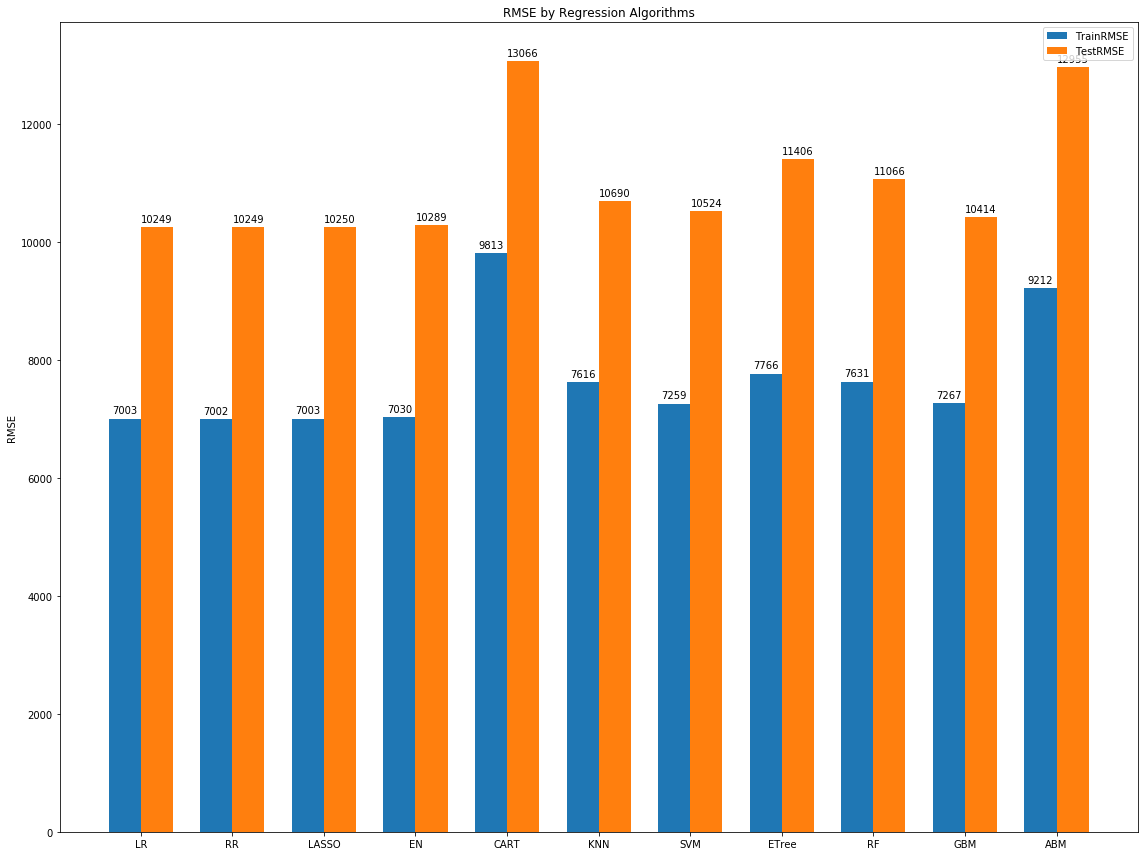

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = names

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

metrics1=[math.floor(item) for item in metrics1]
metrics2=[math.floor(item) for item in metrics2]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics1, width, label='TrainRMSE')
rects2 = ax.bar(x + width/2, metrics2, width, label='TestRMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Regression Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()